# Ejercicio 3: Regresiones locales


---

Construyan una regresión logística pesada y una regresión lineal pesada. Utilizarlas para hacer predicciones sobre los datasets en la carpeta Datos de la clase 4 y muestren mediante gráficos de ejemplo como el parámetro τ afecta los modelos. Además, demuestren que un modelo con un τ muy pequeño tendrá buena performance en train mas no en test en relación con otros τ (es decir, muestre que un τ muy pequeño lleva al overfit).



## 1. Importación de Librerías y Funciones Auxiliares

Importamos las librerías necesarias para manipulación de datos, visualización, métricas y funciones matemáticas.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score


# Función sigmoide estable para evitar problemas numéricos en valores extremos
def sigmoide(x):
    return np.where(
        x >= 0,
        1 / (1 + np.exp(-x)),              # Para x >= 0
        np.exp(x) / (1 + np.exp(x))        # Para x < 0 (evita overflow positivo)
    )

## 2. Definición de la Regresión Lineal Pesada (Local Weighted Regression)

Implementación de la clase para regresión lineal localmente ponderada, explicando los kernels y métodos disponibles.

In [ ]:
class RegresionLinealPesada:
    def __init__(self, tau=1.0, kernel='gaussian'):
        """
        Clase para realizar regresión lineal localmente ponderada (LOESS o LWR).

        Parámetros:
        tau : float
            Ancho del kernel gaussiano o distancia máxima para el kernel tricubo.
        kernel : str {'gaussian', 'tricube'}
            Tipo de kernel a utilizar.
        """
        self.tau = tau  # valor de tau
        self.kernel_type = kernel  # Tipo de kernel a usar

    def _kernel_gaussian(self, query_point, X):
        """Calcula los pesos usando un kernel gaussiano"""
        distances = np.sum((X - query_point) ** 2, axis=1)  # Distancias cuadradas
        return np.exp(-distances / (2 * self.tau ** 2))  # Fórmula del kernel gaussiano

    def _kernel_tricube(self, query_point, X):
        """Calcula los pesos usando el kernel tricubo"""
        distances = np.sqrt(np.sum((X - query_point) ** 2, axis=1))  # Distancia euclídea
        weights = np.zeros_like(distances)  # Inicializar pesos
        mask = distances < self.tau  # Solo se consideran distancias menores a tau
        ratio = distances[mask] / self.tau  # Proporción distancia/tau
        weights[mask] = (1 - ratio**3)**3  # Fórmula del kernel tricubo
        return weights

    def kernel(self, query_point, X):
        """Selecciona el kernel según la configuración"""
        if self.kernel_type == 'gaussian':
            return self._kernel_gaussian(query_point, X)
        elif self.kernel_type == 'tricube':
            return self._kernel_tricube(query_point, X)
        else:
            raise ValueError("Kernel no reconocido. Use 'gaussian' o 'tricube'.")

    def predict(self, X, Y, query_point):
        """Realiza una predicción local en un punto dado"""
        X = X.reshape(-1, 1)  # Asegura que X sea una matriz columna
        query_point = np.array([query_point])  # Convierte a array de una dimensión

        # Agrega término de sesgo (intercepto) a X
        X_ = np.hstack([X, np.ones((X.shape[0], 1))])
        q_ = np.array([[query_point[0], 1]])  # Punto de consulta con sesgo

        # Calcula los pesos para cada punto con respecto al punto de consulta
        W = np.diag(self.kernel(q_[0], X_))  # Matriz diagonal de pesos

        # Ajusta regresión lineal pesada usando fórmula cerrada
        try:
            XtWX = X_.T @ (W @ X_)  # Producto matricial X^T * W * X
            XtWY = X_.T @ (W @ Y)   # Producto matricial X^T * W * Y
            theta = np.linalg.pinv(XtWX) @ XtWY  # Obtiene parámetros (theta)
        except np.linalg.LinAlgError:
            # En caso de que la matriz sea singular, se regulariza
            XtWX += 1e-6 * np.eye(XtWX.shape[0])  # Regularización
            theta = np.linalg.pinv(XtWX) @ XtWY

        # Predicción para el punto de consulta
        return (q_ @ theta).item()

    def fit_and_predict(self, X, Y, X_test):
        """Aplica la regresión para múltiples puntos en X_test"""
        X = X.flatten()  # Asegura que X sea vector 1D
        X_test = X_test.flatten()  # Asegura que X_test sea vector 1D

        Y_pred = []
        for x in X_test:
            pred = self.predict(X, Y, x)  # Predicción para cada punto de test
            Y_pred.append(pred)
        return np.array(Y_pred)

    def score(self, X, Y, X_test, Y_test):
        """Calcula el error cuadrático medio (RMSE) sobre los datos de prueba"""
        Y_pred = self.fit_and_predict(X, Y, X_test)  # Predicciones
        return np.sqrt(np.mean((Y_test - Y_pred) ** 2))  # RMSE

    def fit_and_show(self, X, Y, X_test, ax=None):
        """Entrena, predice y muestra gráfica comparativa de resultados"""
        if ax is None:
            fig, ax = plt.subplots()  # Crea figura si no se proporciona eje

        X_test = np.array(X_test).flatten()  # Asegura que X_test sea vector 1D
        X_test_sorted = np.sort(X_test)  # Ordena los puntos para trazar la línea

        Y_pred = self.fit_and_predict(X, Y, X_test_sorted)  # Predicción sobre puntos ordenados

        # Graficar resultados
        ax.set_title(f"Regresion Lineal pesada (tau = {self.tau})")
        ax.scatter(X, Y, color='red', label='Datos originales', alpha=0.6)  # Puntos originales
        ax.plot(X_test_sorted, Y_pred, color='green', label='Predicciones LWR', linewidth=2)  # Línea de predicción
        ax.legend()
        ax.grid(True)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        return ax  # Devuelve el eje para poder reutilizar


## 3. Carga y división de los datos para regresión lineal

Carga del dataset de regresión y la división de datos en conjuntos de entrenamiento y prueba.

In [ ]:
# Cargar datos
df = pd.read_csv('dataset_regresion.csv')
X = df['X'].values
Y = df['y'].values

# Asegurar formato correcto
Y = Y.reshape(-1, 1)


# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.20, random_state=42)


## 3.1 Exploración visual de los datos de regresión lineal

Visualización de la relación entre X e Y para entender la estructura de los datos.

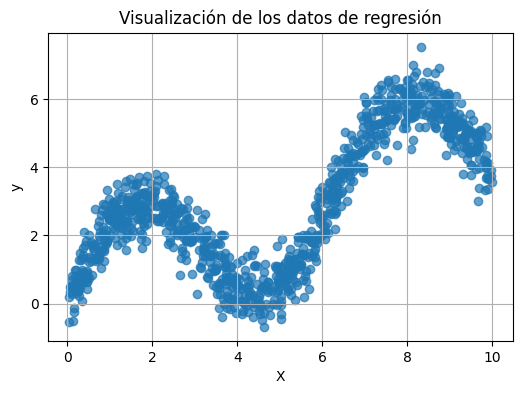

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(X, Y, alpha=0.7)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Visualización de los datos de regresión')
plt.grid(True)
plt.show()

## 4. Visualización del efecto de τ y kernel en la regresión lineal pesada

Muestra de gráficos de cómo diferentes valores de τ y kernels afectan el ajuste del modelo.

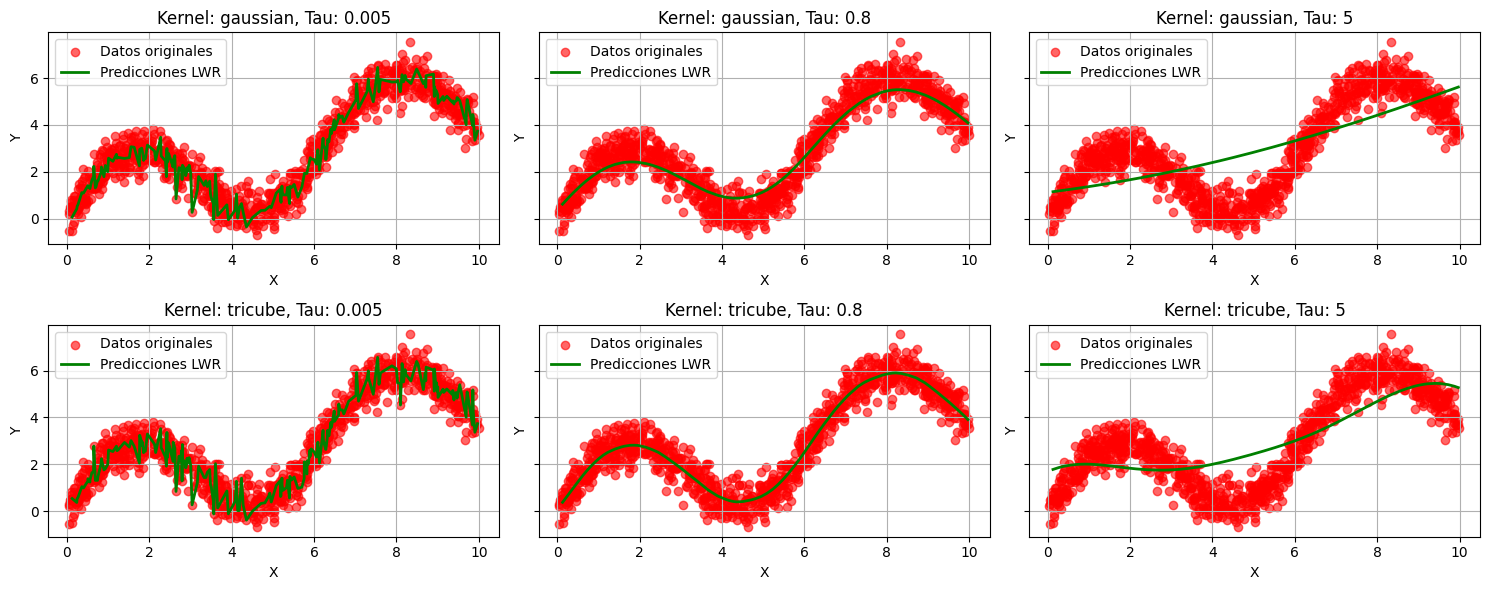

In [ ]:
taus = [0.005, 0.8, 5]
kernels = ['gaussian', 'tricube']

# Crear figura con subplots
fig, axs = plt.subplots(len(kernels), len(taus), figsize=(15, 6), sharey=True)

for i, kernel in enumerate(kernels):
    for j, tau in enumerate(taus):
        model = RegresionLinealPesada(tau=tau, kernel=kernel)
        ax = axs[i, j]
        model.fit_and_show(X, Y, X_test, ax=ax)
        ax.set_title(f"Kernel: {kernel}, Tau: {tau}")

plt.tight_layout()
plt.show()


***Análisis del resultado:***

Se observa que para valores pequeños de τ, el modelo se ajusta muy de cerca a los datos (curva muy flexible), mientras que para valores grandes de τ, la curva es más suave y se aproxima a una regresión lineal global. El kernel afecta la forma de la ponderación, pero el efecto principal lo determina τ.

## 5. Evaluación de overfitting en regresión lineal pesada

Comparación del error en train y test para distintos valores de τ, mostrando el fenómeno de overfitting.

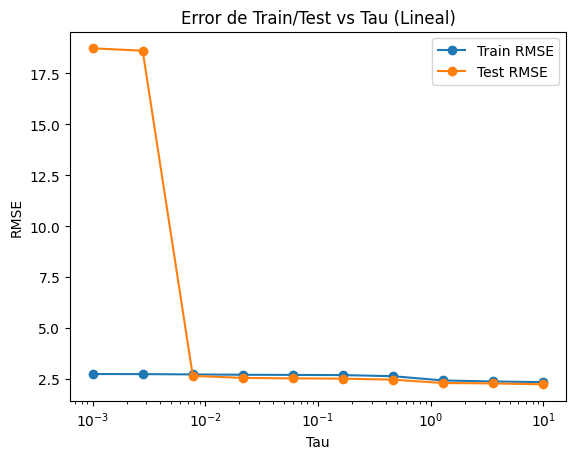

In [ ]:
train_errors = []
test_errors = []
taus_eval = np.logspace(-3, 1, 10)
for tau in taus_eval:
    model = RegresionLinealPesada(tau=tau, kernel='gaussian')
    train_rmse = model.score(X_train, y_train, X_train, y_train)
    test_rmse = model.score(X_train, y_train, X_test, y_test)
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)

plt.plot(taus_eval, train_errors, label='Train RMSE', marker='o')
plt.plot(taus_eval, test_errors, label='Test RMSE', marker='o')
plt.xscale('log')
plt.xlabel('Tau')
plt.ylabel('RMSE')
plt.title('Error de Train/Test vs Tau (Lineal)')
plt.legend()
plt.show()

## 6. Definición de la Regresión Logística Pesada

Implementación de la clase para regresión logística localmente pesado, detallando los kernel y métodos de optimización.

In [ ]:
class RegresionLogisticaPesada:
    def __init__(self, tau=1.0, kernel='gaussian', max_iter=1000, tol=1e-5):
        """
        Inicializa el modelo de Regresión Logística Pesada

        Parámetros:
        - tau: parámetro de ancho de banda del kernel (controla cuán "local" es el ajuste)
        - kernel: tipo de kernel ('gaussian' o 'tricube')
        - max_iter: número máximo de iteraciones para el método de optimización
        - tol: tolerancia para el criterio de parada
        """
        self.tau = tau
        self.kernel = kernel
        self.max_iter = max_iter
        self.tol = tol
        self.X_train = None
        self.y_train = None

    def _kernel_gaussian(self, query_point, X):
        """
        Calcula los pesos del kernel gaussiano con respecto a un punto de consulta

        Parámetros:
        - query_point: punto en el que se desea ajustar localmente
        - X: matriz de entrenamiento (n_samples, n_features)

        Retorna:
        - Vector de pesos (n_samples,)
        """
        distances = np.sum((X - query_point) ** 2, axis=1)  # distancia euclídea al cuadrado
        return np.exp(-distances / (2 * self.tau ** 2))

    def _kernel_tricube(self, query_point, X):
        """
        Kernel tricubo, que decae suavemente y tiene soporte compacto

        Retorna 0 para puntos más alejados que tau
        """
        distances = np.sqrt(np.sum((X - query_point) ** 2, axis=1))  # distancia euclídea
        weights = np.zeros_like(distances)
        mask = distances < self.tau
        ratio = distances[mask] / self.tau
        weights[mask] = (1 - ratio**3)**3  # función tricubo
        return weights

    def _pesos(self, x_query):
        """
        Calcula los pesos locales usando el kernel seleccionado para un punto x_query
        """
        if self.X_train is None:
            raise ValueError('El modelo debe ser entrenado primero con fit(X,y)')

        # Asegura que X_train sea 2D
        X_train_internal = self.X_train
        if X_train_internal.ndim == 1:
            X_train_internal = X_train_internal.reshape(-1, 1)

        # Selección del kernel
        if self.kernel == 'gaussian':
            if self.tau <= 0:
                raise ValueError('tau debe ser positivo para el kernel gaussiano.')
            return self._kernel_gaussian(x_query, X_train_internal)
        elif self.kernel == 'tricube':
            return self._kernel_tricube(x_query, X_train_internal)
        else:
            raise ValueError("Kernel no reconocido. Use 'gaussian' o 'tricube'.")

    def _fit_local_newton(self, x_query):
        """
        Ajusta los parámetros theta localmente en torno a x_query usando el método de Newton-Raphson

        Retorna:
        - theta óptimo para ese punto de consulta
        """
        X = self.X_train
        y = self.y_train

        # Asegura que X sea 2D
        if X.ndim == 1:
            X = X.reshape(-1, 1)

        # Obtiene los pesos del kernel centrado en x_query
        weights = self._pesos(x_query)
        W = np.diag(weights)

        # Agrega columna de unos para el término independiente (bias)
        X_ = np.hstack([np.ones((X.shape[0], 1)), X])
        theta = np.zeros(X_.shape[1])

        for _ in range(self.max_iter):
            h = sigmoide(X_ @ theta)  # Predicción actual

            # R es una matriz diagonal con h(1-h), usamos piso para evitar ceros
            R_ii = np.maximum(h * (1 - h), 1e-10)
            R = np.diag(R_ii)

            # Gradiente y hessiano local
            grad = X_.T @ W @ (h - y)
            H = X_.T @ W @ R @ X_

            try:
                delta = np.linalg.inv(H) @ grad  # paso de Newton
            except np.linalg.LinAlgError:
                # Regularización por si H es singular
                H_reg = H + 1e-10 * np.eye(X_.shape[1])
                delta = np.linalg.pinv(H_reg) @ grad

            # Criterio de parada
            if np.linalg.norm(delta) < self.tol:
                break

            theta -= delta  # actualiza parámetros

        return theta


    def _fit_local_gd(self, x_query, learning_rate=0.01):
        """
        Ajuste local usando descenso de gradiente en lugar de Newton-Raphson
        """
        X = self.X_train
        y = self.y_train

        if X.ndim == 1:
            X = X.reshape(-1, 1)

        weights = self._pesos(x_query)
        W = np.diag(weights)

        X_ = np.hstack([np.ones((X.shape[0], 1)), X])
        theta = np.zeros(X_.shape[1])

        for _ in range(self.max_iter):
            h = sigmoide(X_ @ theta)
            gradient = X_.T @ (W @ (h - y))

            if np.linalg.norm(gradient) < self.tol:
                break

            theta -= learning_rate * gradient

        return theta

    def _fit_local_gd_momentum(self, x_query, learning_rate=0.01,beta=0.9):

        """
        Ajuste local usando descenso de gradiente con momentum
        """
        X = self.X_train
        y = self.y_train

        if X.ndim == 1:
            X = X.reshape(-1, 1)

        weights = self._pesos(x_query)
        W = np.diag(weights)

        X_ = np.hstack([np.ones((X.shape[0], 1)), X])
        theta = np.zeros(X_.shape[1])
        velocidad = np.zeros_like(theta)  # Inicializa la velocidad

        for _ in range(self.max_iter):
            h = sigmoide(X_ @ theta)
            gradient = X_.T @ (W @ (h - y))


            if np.linalg.norm(gradient) < self.tol:
                break

             # Actualización con momentum
            velocidad = beta * velocidad + learning_rate * gradient
            theta -= velocidad  # # Actualiza theta usando la dirección acumulada del momentum

        return theta



    def fit(self, X, y):
        """
        Almacena los datos de entrenamiento (no entrena directamente ya que el ajuste es local)
        """
        self.X_train = np.asarray(X)
        self.y_train = np.asarray(y).ravel()

        if self.X_train.ndim == 1:
            self.X_train = self.X_train.reshape(-1, 1)

        return self


    def predict_proba(self, X_test, method='newton', learning_rate=0.01, beta=0.9):
        """
        Calcula las probabilidades predichas para cada muestra de test
        utilizando regresión logística local

        Retorna:
        - Vector de probabilidades (n_samples,)
        """
        X_test_internal = np.atleast_2d(X_test)

        if self.X_train is None:
            raise ValueError('El modelo debe ser entrenado primero con fit(X,y).')

        n_features_train = self.X_train.shape[1]

        if X_test_internal.shape[1] != n_features_train:
            if X_test_internal.shape[0] == n_features_train and X_test.ndim == 1:
                X_test_internal = X_test_internal.reshape(1, n_features_train)
            else:
                raise ValueError('Dimensiones incompatibles entre X_test y X_train')

        probs = []
        for i in range(X_test_internal.shape[0]):
            x_query = X_test_internal[i, :]

            # Selección del método de optimización local
            if method == 'newton':
                theta = self._fit_local_newton(x_query)
            elif method == 'gd':
                theta = self._fit_local_gd(x_query, learning_rate=learning_rate)
            elif method == 'gd_momentum':
                theta = self._fit_local_gd_momentum(x_query, learning_rate=learning_rate,beta=beta)

            else:
                raise ValueError("Método no reconocido. Use 'newton' ,'gd' o 'gd_momentum'.")

            x_aug = np.hstack([1, x_query])  # añade término independiente
            probs.append(sigmoide(x_aug @ theta))

        return np.array(probs)


    def predict(self, X_test, method='newton', learning_rate=0.01, umbral=0.5):
        """
        Predice clases 0/1 basado en la probabilidad y un umbral
        """
        probs = self.predict_proba(X_test, method=method, learning_rate=learning_rate)
        return (probs >= umbral).astype(int)


    def plot_decision_boundary(self, X, y, method='newton', learning_rate=0.01, resolution=50, umbral=0.5, padding=0.1, beta=0.9,ax=None):
        """
        Visualiza la frontera de decisión para datos bidimensionales (2 features)
        """
        if X.shape[1] != 2:
            raise ValueError('Solo se puede graficar la frontera de decisión para datos con 2 características.')

        if self.X_train is None or self.y_train is None:
            print('Advertencia: El modelo no ha sido ajustado. Se usará fit(X,y) solo para graficar.')
            self.fit(X, y)

        # Define la malla de puntos para evaluar
        x_min, x_max = X[:, 0].min() - padding, X[:, 0].max() + padding
        y_min, y_max = X[:, 1].min() - padding, X[:, 1].max() + padding
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                             np.linspace(y_min, y_max, resolution))
        grid_points = np.c_[xx.ravel(), yy.ravel()]

        # Predice probabilidades para cada punto de la malla
        Z = self.predict_proba(grid_points, method=method, learning_rate=learning_rate,
                               beta=beta)
        Z = Z.reshape(xx.shape)

        # Graficar
        if ax is None:
            fig, ax = plt.subplots()

        # Contorno de la frontera de decisión

        ax.contourf(xx, yy, Z, levels=np.linspace(0, 1, 100), cmap='RdBu_r', alpha=0.6)
        ax.contour(xx, yy, Z, levels=[umbral], colors='black', linewidths=2, linestyles='--')
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu_r', edgecolors='k', s=80, zorder=2)

        ax.set_title(f'Frontera de decisión (tau={self.tau})')
        ax.set_xlabel('Característica 1')
        ax.set_ylabel('Característica 2')
        ax.grid(True, linestyle=':', alpha=0.7)
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())


## 7. Carga y división de los datos para regresión logística

Carga del dataset de clasificación y divición de los datos en conjuntos de entrenamiento y prueba.

In [ ]:
df = pd.read_csv('dataset_clasificacion.csv')
X_clas=df[['X1','X2']].to_numpy()
y_clas=df[['Clase']].to_numpy()
y_clas=y_clas.ravel()
X_train, X_test, y_train, y_test = train_test_split(X_clas, y_clas, test_size=0.2, random_state=42)


## 7.1 Exploración visual de los datos de clasificación

Visualización de los datos en el espacio de características para observar la separación entre clases.

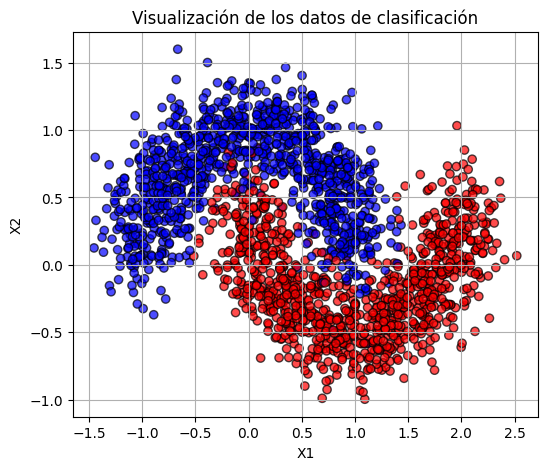

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(X_clas[:,0], X_clas[:,1], c=y_clas, cmap='bwr', alpha=0.7, edgecolor='k')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Visualización de los datos de clasificación')
plt.grid(True)
plt.show()

## 8. Visualización del efecto de τ y kernel en regresión logística pesada

Graficos de la frontera de decisión para distintos valores de τ y métodos de optimización.

<ipython-input-1-68d3d5385fc4>:13: RuntimeWarning: overflow encountered in exp
  np.exp(x) / (1 + np.exp(x))        # Para x < 0 (evita overflow positivo)
<ipython-input-1-68d3d5385fc4>:13: RuntimeWarning: invalid value encountered in divide
  np.exp(x) / (1 + np.exp(x))        # Para x < 0 (evita overflow positivo)
<ipython-input-1-68d3d5385fc4>:12: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-x)),              # Para x >= 0


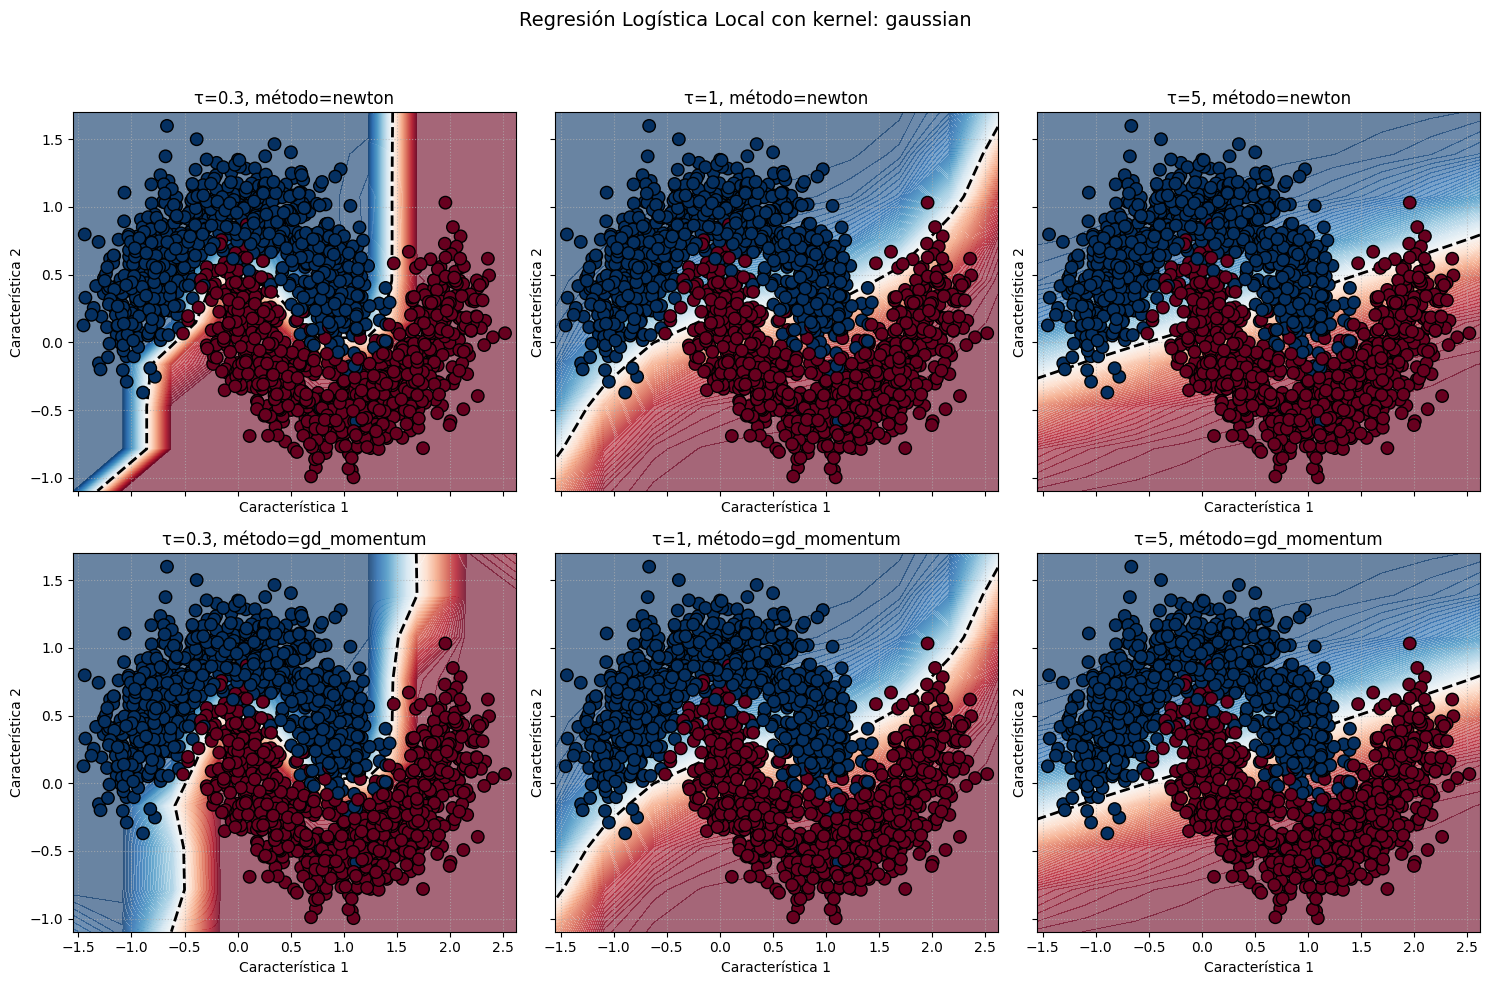

Tiempo de ejecución: 336.44 segundos


In [ ]:
import time

start = time.time()

taus = [0.3, 1, 5]
methods = ['newton', 'gd_momentum']# se utilizan newton rapson y descenso por gradiente con optimización momentum
kernels = ['gaussian']

for kernel in kernels:
    fig, axs = plt.subplots(len(methods), len(taus), figsize=(15, 10), sharex=True, sharey=True)
    fig.suptitle(f"Regresión Logística Local con kernel: {kernel}", fontsize=14)

    for i, method in enumerate(methods):
        for j, tau in enumerate(taus):
            ax = axs[i, j]
            model = RegresionLogisticaPesada(tau=tau, kernel=kernel, tol=1e-3)
            model.fit(X_train, y_train)
            # Usa solo los datos de entrenamiento y una grilla muy baja
            model.plot_decision_boundary(X_train, y_train, method=method, ax=ax, resolution=10)
            ax.set_title(f"τ={tau}, método={method}")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    end = time.time()
print(f"Tiempo de ejecución: {end - start:.2f} segundos")

***Análisis del resultado:***

Se observa que con τ pequeño, la frontera de decisión se ajusta mucho a los puntos de entrenamiento, capturando incluso el ruido. A medida que τ aumenta, la frontera se suaviza y generaliza mejor.

## 9. Evaluación de overfitting en regresión logística pesada

Analisis del accuracy en train y test para distintos τ, evidenciando el overfitting cuando τ es pequeño.

 ***Decisión:***

 Como el modelo es lento computacionalmente tomamos una submuestra aleatoria del 20% del conjunto de entrenamiento y evaluamos el modelo en esa porción, sin usarla para entrenar específicamente. Cuando τ es muy pequeño, el modelo se ajusta excesivamente a los datos, logrando un accuracy alto en la submuestra, pero con bajo desempeño en test.

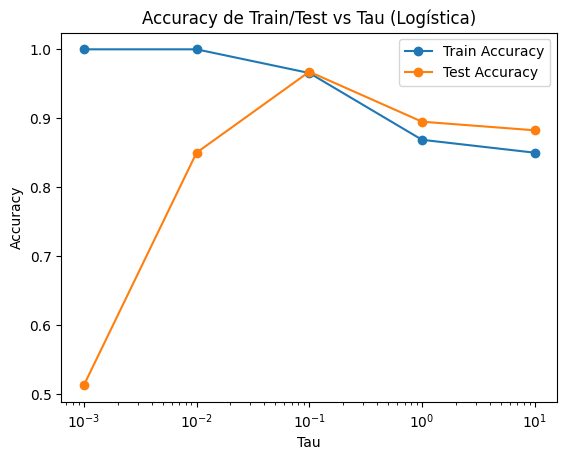

Tiempo de ejecución: 578.38 segundos


In [ ]:
import time

start = time.time()

# Tomar el 20% del conjunto de entrenamiento
frac = 0.2
n_samples = int(X_train.shape[0] * frac)

# índice aleatorio sin reemplazo
idx = np.random.choice(X_train.shape[0], size=n_samples, replace=False)

# submuestras
X_train_sub = X_train[idx]
y_train_sub = y_train[idx]

taus_eval = np.logspace(-3, 1,5)

train_acc = []
test_acc = []

for tau in taus_eval:
    model = RegresionLogisticaPesada(tau=tau, kernel='gaussian',max_iter=100,tol=1e-3)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train_sub,method='gd_momentum')
    y_test_pred = model.predict(X_test,method='gd_momentum')
    train_acc.append(accuracy_score(y_train_sub, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

plt.plot(taus_eval, train_acc, label='Train Accuracy', marker='o')
plt.plot(taus_eval, test_acc, label='Test Accuracy', marker='o')
plt.xscale('log')
plt.xlabel('Tau')
plt.ylabel('Accuracy')
plt.title('Accuracy de Train/Test vs Tau (Logística)')
plt.legend()
plt.show()

end = time.time()
print(f"Tiempo de ejecución: {end - start:.2f} segundos")

## 10. Conclusión final


En este ejercicio probamos regresión lineal y logística localmente pesada usando distintos kernels y valores de τ. Lo más importante que notamos es que τ cambia mucho el comportamiento del modelo: si es muy chico, el modelo se ajusta demasiado y no generaliza (overfitting), y si es muy grande, el modelo se vuelve muy rígido y no capta bien la forma de los datos. Es decir hace una separación lineal y es como si fuera una regresión lógistica común, con lo cual se pierde la flexibilidad que esperamos del modelo.

Una de las cosas más complicadas fue que la regresión logística local tarda bastante en ejecutarse, así que tuvimos que usar menos datos y probar distintas optizaciones para que no se hiciera eterno. También costó un poco interpretar cuándo el modelo estaba sobreajustando y cuándo no, porque depende mucho del dataset y de τ.

Por último, entendemos que elegir τ es clave, hay que probar y probar, mirar los gráficos y las métricas para ajustar bien los parámetros del problema dado.